In [17]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('panda-and-spark').getOrCreate()

sc = spark.sparkContext

In [18]:
from pyspark.sql.types import *

# structure of the training data set
train_schema = StructType([
    StructField('date', DateType()),
    StructField('store', IntegerType()),
    StructField('item', IntegerType()),
    StructField('sales', IntegerType())
])

# read the training file into a dataframe
train = spark.read.csv(
    'sales-data.csv',
    header=True,
    schema=train_schema
)

# make the dataframe queryable as a temporary view
train.createOrReplaceTempView('train')

# show data
display(train)

DataFrame[date: date, store: int, item: int, sales: int]

In [19]:
# query to aggregate data to date (ds) level
sql_statement = '''
  SELECT
    CAST(date as date) as ds,
    sales as y
  FROM train
  WHERE store=1 AND item=1
  ORDER BY ds
  '''

# assemble dataset in Pandas dataframe
history_pd = spark.sql(sql_statement).toPandas()

# drop any missing records
history_pd = history_pd.dropna()

In [20]:
from prophet import Prophet
import logging

# disable informational messages from prophet
logging.getLogger('py4j').setLevel(logging.ERROR)

In [21]:
# set model parameters
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)

# fit the model to historical data
model.fit(history_pd)

23:16:15 - cmdstanpy - INFO - Chain [1] start processing
23:16:15 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# define a dataset including both historical dates & 90-days beyond the last available date
future_pd = model.make_future_dataframe(
    periods=90,
    freq='d',
    include_history=True
)

# predict over the dataset
forecast_pd = model.predict(future_pd)

display(forecast_pd)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2013-01-01,15.602150,1.238645,18.347519,15.602150,15.602150,-0.355968,-0.355968,-0.355968,-0.088795,-0.088795,-0.088795,-0.267173,-0.267173,-0.267173,0.0,0.0,0.0,10.048283
1,2013-01-02,15.607853,1.661002,19.055819,15.607853,15.607853,-0.325653,-0.325653,-0.325653,-0.058994,-0.058994,-0.058994,-0.266659,-0.266659,-0.266659,0.0,0.0,0.0,10.525112
2,2013-01-03,15.613557,2.178315,20.034054,15.613557,15.613557,-0.292334,-0.292334,-0.292334,-0.025377,-0.025377,-0.025377,-0.266957,-0.266957,-0.266957,0.0,0.0,0.0,11.049186
3,2013-01-04,15.619260,3.552605,19.996276,15.619260,15.619260,-0.216383,-0.216383,-0.216383,0.051644,0.051644,0.051644,-0.268027,-0.268027,-0.268027,0.0,0.0,0.0,12.239510
4,2013-01-05,15.624963,5.049449,21.921606,15.624963,15.624963,-0.118449,-0.118449,-0.118449,0.151358,0.151358,0.151358,-0.269806,-0.269806,-0.269806,0.0,0.0,0.0,13.774209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911,2018-03-27,22.777971,11.555121,29.218589,22.749177,22.807794,-0.118383,-0.118383,-0.118383,-0.088795,-0.088795,-0.088795,-0.029588,-0.029588,-0.029588,0.0,0.0,0.0,20.081444
1912,2018-03-28,22.779736,12.301401,29.828177,22.750511,22.809754,-0.085716,-0.085716,-0.085716,-0.058994,-0.058994,-0.058994,-0.026722,-0.026722,-0.026722,0.0,0.0,0.0,20.827148
1913,2018-03-29,22.781502,13.595884,30.062144,22.751850,22.811774,-0.049253,-0.049253,-0.049253,-0.025377,-0.025377,-0.025377,-0.023876,-0.023876,-0.023876,0.0,0.0,0.0,21.659453
1914,2018-03-30,22.783267,15.371613,32.886718,22.753190,22.813922,0.030651,0.030651,0.030651,0.051644,0.051644,0.051644,-0.020992,-0.020992,-0.020992,0.0,0.0,0.0,23.481607


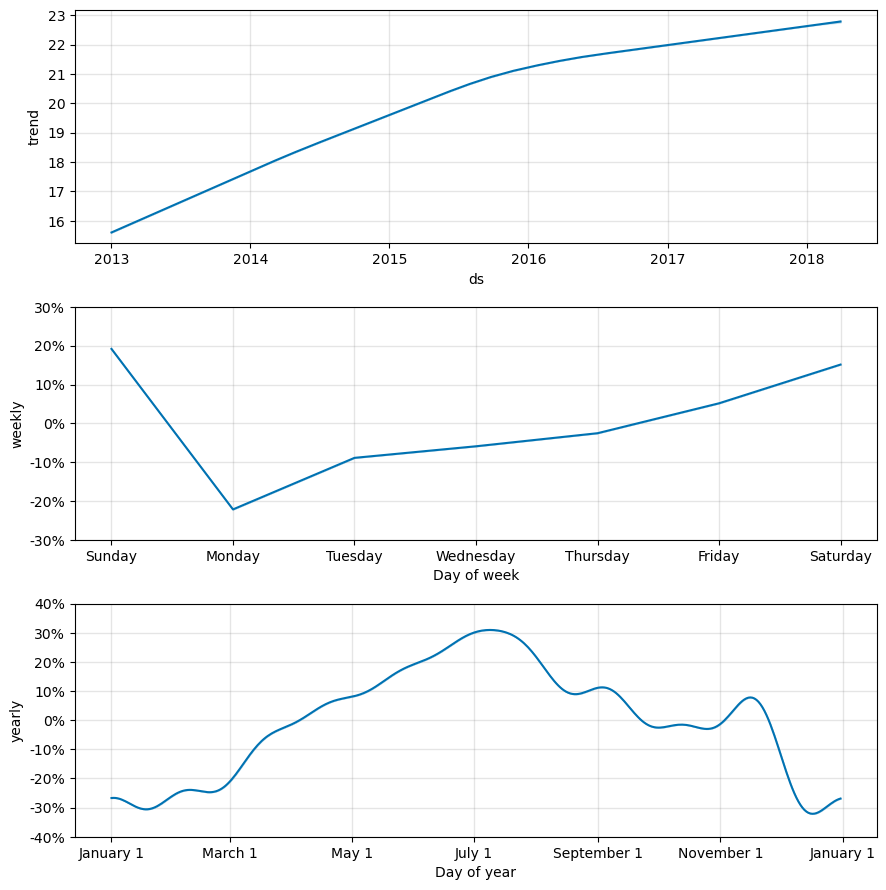

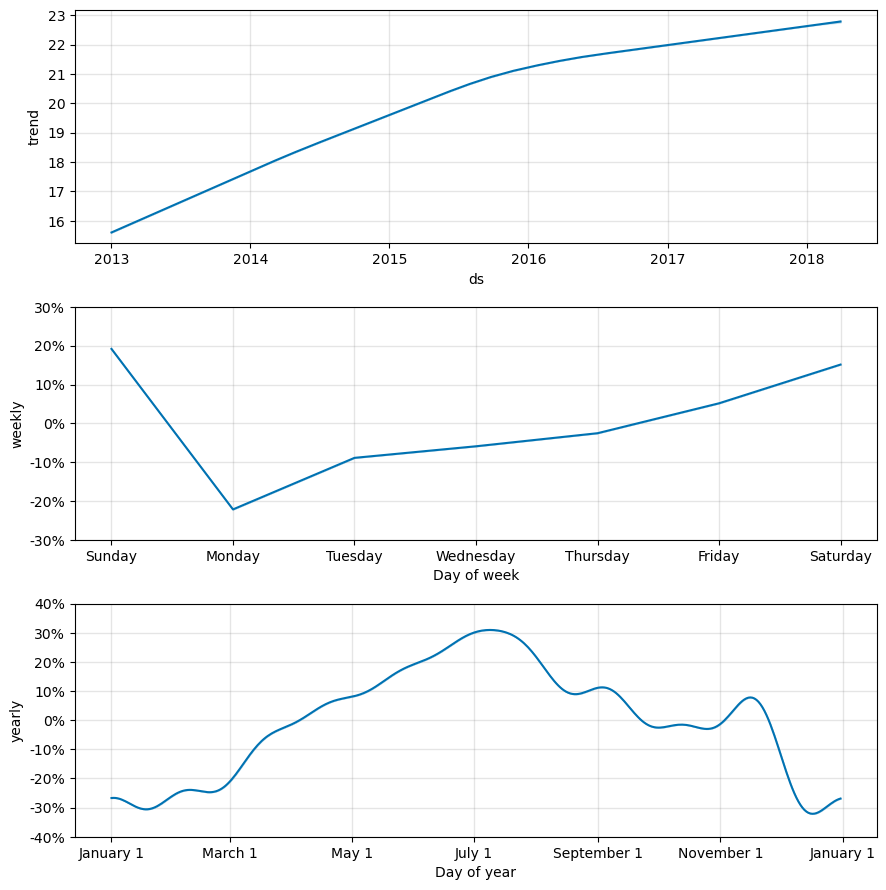

In [23]:
trends_fig = model.plot_components(forecast_pd)
display(trends_fig)

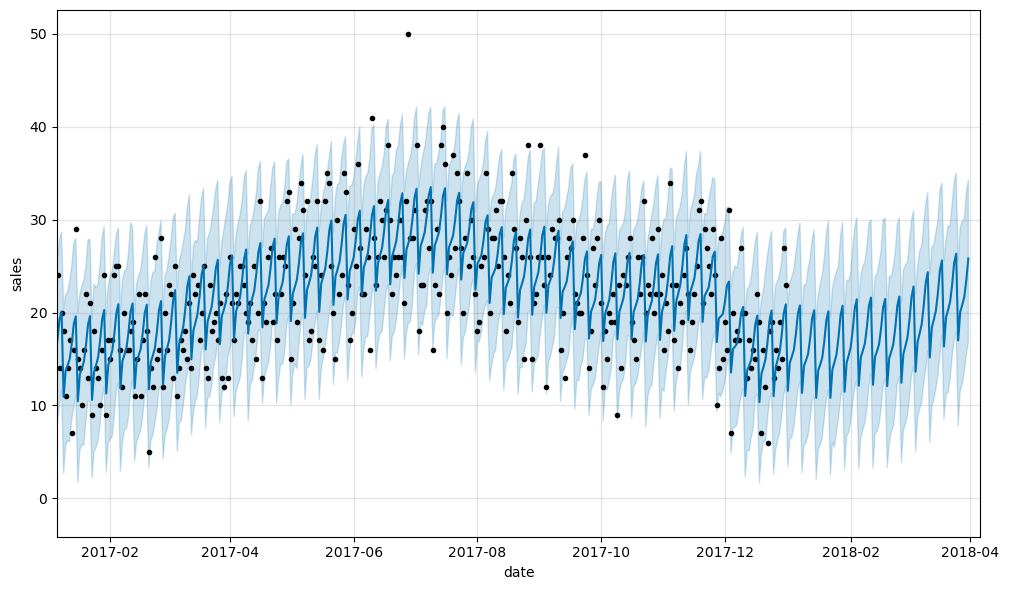

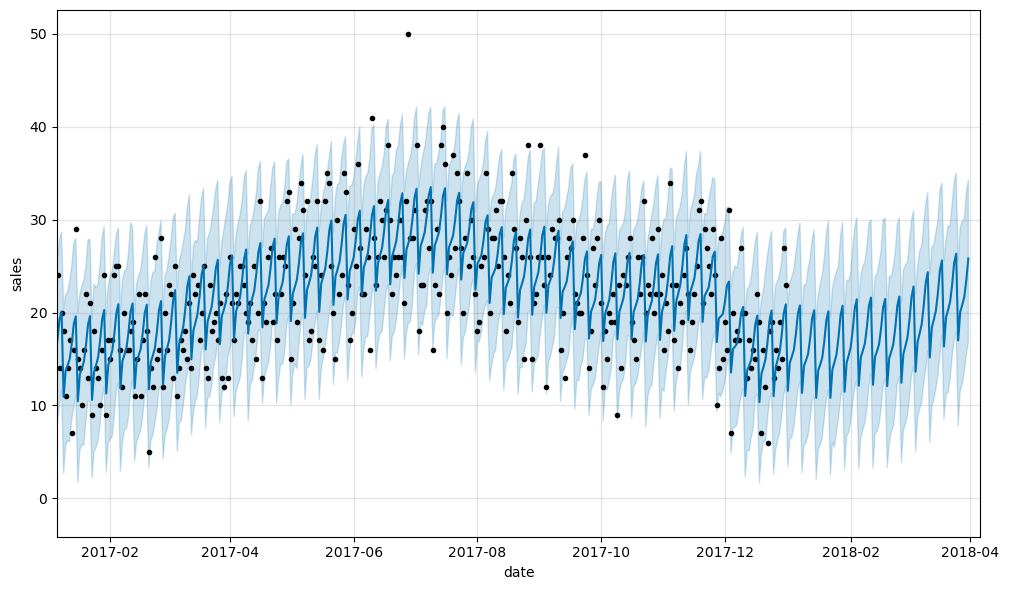

In [24]:
predict_fig = model.plot( forecast_pd, xlabel='date', ylabel='sales')

# adjust figure to display dates from last year + the 90 day forecast
xlim = predict_fig.axes[0].get_xlim()
new_xlim = ( xlim[1]-(180.0+365.0), xlim[1]-90.0)
predict_fig.axes[0].set_xlim(new_xlim)

display(predict_fig)

In [25]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from datetime import date

# get historical actuals & predictions for comparison
actuals_pd = history_pd[ history_pd['ds'] < date(2018, 1, 1) ]['y']
predicted_pd = forecast_pd[ forecast_pd['ds'] < pd.to_datetime('2018-01-01') ]['yhat']

# calculate evaluation metrics
mae = mean_absolute_error(actuals_pd, predicted_pd)
mse = mean_squared_error(actuals_pd, predicted_pd)
rmse = sqrt(mse)

# print metrics to the screen
print( '\n'.join(['MAE: {0}', 'MSE: {1}', 'RMSE: {2}']).format(mae, mse, rmse) )

MAE: 3.486501856729764
MSE: 19.38851616612048
RMSE: 4.403239281043046


In [27]:
sql_statement = '''
  SELECT
    store,
    item,
    CAST(date as date) as ds,
    SUM(sales) as y
  FROM train
  GROUP BY store, item, ds
  ORDER BY store, item, ds
  '''

store_item_history = (
    spark
    .sql( sql_statement )
    .repartition(sc.defaultParallelism, ['store', 'item'])
).cache()

In [37]:
number_of_partitions = store_item_history.rdd.getNumPartitions()

print("Number of partitions:", number_of_partitions)

Number of partitions: 12


In [38]:
# Initialize SparkSession with all available cores
spark = SparkSession.builder.master("local[*]").appName("Parallel Workload").getOrCreate()

# Parallelize the workload using an RDD
data = [1, 2, 3, 4, 5]
rdd = spark.sparkContext.parallelize(data, numSlices=5)  # Create 5 partitions

# Define a transformation that can be executed in parallel
rdd_squared = rdd.map(lambda x: x**2)

# Collect the results
squared_results = rdd_squared.collect()

print(squared_results)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 14.0 failed 1 times, most recent failure: Lost task 4.0 in stage 14.0 (TID 54) (LAPTOP-2F01IBON executor driver): java.io.IOException: Cannot run program "python3": CreateProcess error=3, The system cannot find the path specified
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1048)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:181)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: CreateProcess error=3, The system cannot find the path specified
	at java.lang.ProcessImpl.create(Native Method)
	at java.lang.ProcessImpl.<init>(ProcessImpl.java:453)
	at java.lang.ProcessImpl.start(ProcessImpl.java:139)
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1029)
	... 18 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1046)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1045)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: Cannot run program "python3": CreateProcess error=3, The system cannot find the path specified
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1048)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:181)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.io.IOException: CreateProcess error=3, The system cannot find the path specified
	at java.lang.ProcessImpl.create(Native Method)
	at java.lang.ProcessImpl.<init>(ProcessImpl.java:453)
	at java.lang.ProcessImpl.start(ProcessImpl.java:139)
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1029)
	... 18 more


In [28]:
from pyspark.sql.types import *

result_schema =StructType([
    StructField('ds',DateType()),
    StructField('store',IntegerType()),
    StructField('item',IntegerType()),
    StructField('y',FloatType()),
    StructField('yhat',FloatType()),
    StructField('yhat_upper',FloatType()),
    StructField('yhat_lower',FloatType())
])

In [34]:
def forecast_store_item( history_pd: pd.DataFrame ) -> pd.DataFrame:

    # TRAIN MODEL AS BEFORE
    # --------------------------------------
    # remove missing values (more likely at day-store-item level)
    history_pd = history_pd.dropna()

    # configure the model
    model = Prophet(
        interval_width=0.95,
        growth='linear',
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative'
    )

    # train the model
    model.fit( history_pd )
    # --------------------------------------

    # BUILD FORECAST AS BEFORE
    # --------------------------------------
    # make predictions
    future_pd = model.make_future_dataframe(
        periods=90,
        freq='d',
        include_history=True
    )
    forecast_pd = model.predict( future_pd )
    # --------------------------------------

    # ASSEMBLE EXPECTED RESULT SET
    # --------------------------------------
    # get relevant fields from forecast
    f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')

    # get relevant fields from history
    h_pd = history_pd[['ds','store','item','y']].set_index('ds')

    # join history and forecast
    results_pd = f_pd.join( h_pd, how='left' )
    results_pd.reset_index(level=0, inplace=True)

    # get store & item from incoming data set
    results_pd['store'] = history_pd['store'].iloc[0]
    results_pd['item'] = history_pd['item'].iloc[0]
    # --------------------------------------

    # return expected dataset
    return results_pd[ ['ds', 'store', 'item', 'y', 'yhat', 'yhat_upper', 'yhat_lower'] ]  

In [35]:
from pyspark.sql.functions import current_date

results = (
    store_item_history
    .groupBy('store', 'item')
    .applyInPandas(forecast_store_item, schema=result_schema)
    .withColumn('training_date', current_date() )
)

results.createOrReplaceTempView('new_forecasts')

display(results)

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: PyArrow >= 4.0.0 must be installed; however, it was not found.

In [33]:
# schema of expected result set
eval_schema =StructType([
    StructField('training_date', DateType()),
    StructField('store', IntegerType()),
    StructField('item', IntegerType()),
    StructField('mae', FloatType()),
    StructField('mse', FloatType()),
    StructField('rmse', FloatType())
])

# define function to calculate metrics
def evaluate_forecast( evaluation_pd: pd.DataFrame ) -> pd.DataFrame:

    # get store & item in incoming data set
    training_date = evaluation_pd['training_date'].iloc[0]
    store = evaluation_pd['store'].iloc[0]
    item = evaluation_pd['item'].iloc[0]

    # calculate evaluation metrics
    mae = mean_absolute_error( evaluation_pd['y'], evaluation_pd['yhat'] )
    mse = mean_squared_error( evaluation_pd['y'], evaluation_pd['yhat'] )
    rmse = sqrt( mse )

    # assemble result set
    results = {'training_date':[training_date], 'store':[store], 'item':[item], 'mae':[mae], 'mse':[mse], 'rmse':[rmse]}
    return pd.DataFrame.from_dict( results )

# calculate metrics
results = (
    spark
    .table('new_forecasts')
    .filter('ds < \'2018-01-01\'') # limit evaluation to periods where we have historical data
    .select('training_date', 'store', 'item', 'y', 'yhat')
    .groupBy('training_date', 'store', 'item')
    .applyInPandas(evaluate_forecast, schema=eval_schema)
)

results.createOrReplaceTempView('new_forecast_evals')

Py4JJavaError: An error occurred while calling o24.table.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:735)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:270)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:286)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:978)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:660)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:700)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:788)
	at org.apache.spark.sql.catalyst.catalog.InMemoryCatalog.liftedTree1$1(InMemoryCatalog.scala:122)
	at org.apache.spark.sql.catalyst.catalog.InMemoryCatalog.createDatabase(InMemoryCatalog.scala:119)
	at org.apache.spark.sql.internal.SharedState.externalCatalog$lzycompute(SharedState.scala:159)
	at org.apache.spark.sql.internal.SharedState.externalCatalog(SharedState.scala:140)
	at org.apache.spark.sql.internal.BaseSessionStateBuilder.$anonfun$catalog$1(BaseSessionStateBuilder.scala:154)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.externalCatalog$lzycompute(SessionCatalog.scala:122)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.externalCatalog(SessionCatalog.scala:122)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.databaseExists(SessionCatalog.scala:319)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.requireDbExists(SessionCatalog.scala:249)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.getTableRawMetadata(SessionCatalog.scala:540)
	at org.apache.spark.sql.catalyst.catalog.SessionCatalog.getTableMetadata(SessionCatalog.scala:526)
	at org.apache.spark.sql.execution.datasources.v2.V2SessionCatalog.loadTable(V2SessionCatalog.scala:75)
	at org.apache.spark.sql.connector.catalog.CatalogV2Util$.getTable(CatalogV2Util.scala:355)
	at org.apache.spark.sql.connector.catalog.CatalogV2Util$.loadTable(CatalogV2Util.scala:336)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.$anonfun$resolveRelation$3(Analyzer.scala:1268)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.$anonfun$resolveRelation$1(Analyzer.scala:1267)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.org$apache$spark$sql$catalyst$analysis$Analyzer$ResolveRelations$$resolveRelation(Analyzer.scala:1259)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$$anonfun$apply$14.applyOrElse(Analyzer.scala:1123)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$$anonfun$apply$14.applyOrElse(Analyzer.scala:1087)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$3(AnalysisHelper.scala:138)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:138)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:323)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:134)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:130)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.apply(Analyzer.scala:1087)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveRelations$.apply(Analyzer.scala:1046)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:222)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:91)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:219)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:211)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:211)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:226)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:222)
	at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:173)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:222)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:188)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:182)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:182)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:209)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:330)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:208)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$analyzed$1(QueryExecution.scala:77)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:138)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:219)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:219)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:218)
	at org.apache.spark.sql.execution.QueryExecution.analyzed$lzycompute(QueryExecution.scala:77)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:74)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:66)
	at org.apache.spark.sql.Dataset$.$anonfun$ofRows$1(Dataset.scala:91)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:89)
	at org.apache.spark.sql.DataFrameReader.table(DataFrameReader.scala:608)
	at org.apache.spark.sql.SparkSession.table(SparkSession.scala:602)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:547)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:568)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:591)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:688)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:79)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1907)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1867)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1840)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:242)
	at org.apache.spark.util.SparkFileUtils.createTempDir(SparkFileUtils.scala:103)
	at org.apache.spark.util.SparkFileUtils.createTempDir$(SparkFileUtils.scala:102)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:94)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:372)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:964)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:194)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:217)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:91)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1120)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1129)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:467)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:438)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:515)
	... 25 more
